In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from dateutil.parser import parse as date_parse
import requests
%matplotlib inline
pd.options.mode.chained_assignment = None

In [4]:
jhu_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/' \
                       'COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' \
                       'time_series_covid19_confirmed_global.csv')
# https://www.soothsawyer.com/john-hopkins-time-series-data-confirmed-case-csv-after-march-22-2020/
jhu_data = pd.read_csv('https://www.soothsawyer.com/wp-content/uploads/' \
           '2020/03/time_series_19-covid-Confirmed.csv')
jhu_data_deaths = pd.read_csv('https://www.soothsawyer.com/wp-content/uploads/2020/03/time_series_19-covid-Deaths.csv')

r=requests.get('https://covidtracking.com/api/states/daily')
covidtracking_data = pd.DataFrame(r.json())

# this is the URL to the CSV file in GitHub so you can parse date of last commit.
# (the REST API required auth)
JHU_DATA_FILE_URL = 'https://github.com/CSSEGISandData/COVID-19/blob/master/' \
                     'csse_covid_19_data/csse_covid_19_time_series/' \
                     'time_series_covid19_confirmed_global.csv'

In [5]:
covidtracking_data_ = covidtracking_data.copy()
covidtracking_data_['dateChecked'] = covidtracking_data_['dateChecked'].map(lambda x: date_parse(x))
covidtracking_data_['date'] = covidtracking_data_['date'].map(lambda x: date_parse(str(x)))
covidtracking_reduced = covidtracking_data_.groupby(['state', 'date']).sum().reset_index()

In [6]:
country_filter = ['China', 'South Korea', 'Italy', 'France', 'Spain', 'United States']

In [7]:
country_mapper = {
        'Korea, South': 'South Korea',
        'US': 'United States'    
}
jhu_data['Country/Region'] = jhu_data['Country/Region'].map(country_mapper).fillna(jhu_data['Country/Region'])

In [8]:
assert set(country_filter) - set(jhu_data['Country/Region']) == set()

In [21]:
def jhu_data_processing(df, t0_threshold=100, states_data=False):
    loc = 'location' if not states_data else 'state'
    df['Country/Region'] = df['Country/Region'].map(country_mapper).fillna(df['Country/Region'])
    if states_data:
        df = df[df['Country/Region'] == 'United States']
        df['Province/State'] = df['Province/State'].map(drop_cities).dropna()
        df = df.drop(columns=['Lat', 'Long', 'Country/Region'])
        df = df.groupby('Province/State').max()
    else:
        df = df.drop(columns=['Lat', 'Long', 'Province/State'])
        df = df.groupby('Country/Region').max()
    df = df.stack().reset_index()
    df.columns = [loc, 'date', 'total']
    df['date'] = pd.to_datetime(df['date'])
    if not states_data:
        df = df.query('total >= @t0_threshold')
        t0_date = df.groupby(loc).min()['date']
        df.loc[:, 't0_date'] = pd.to_datetime(df[loc].map(t0_date))
        df.loc[:, 'since_t0'] = df['date'] - df['t0_date']
        df.loc[:, 'since_t0']  = df['since_t0'].map(lambda x: x.days)
        df.loc[:, 'since_t0'] = df.loc[:, 'since_t0'].where(df['since_t0'] > 0, 0)
    return df

In [10]:
state_abbr = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
state_lookup = state_abbr.set_index('Abbreviation', drop=True).squeeze().to_dict()

In [11]:
def get_state(place):
    p = place.split(',')
    if len(p) > 1:
        return state_lookup[p[1].replace('.', '').strip()]
    return place
def drop_cities(place):
    if place.find(',') > 0:
        return None
    else:
        return place

In [13]:
jhu_data_t0 = jhu_data_processing(jhu_data)
jhu_data_us_reduced = jhu_data_processing(jhu_data, states_data=True)

In [25]:
jhu_deaths_data_t0 = jhu_data_processing(jhu_data_deaths, t0_threshold=10)
jhu_deaths_data_us_reduced = jhu_data_processing(jhu_data_deaths, states_data=True, t0_threshold=50)

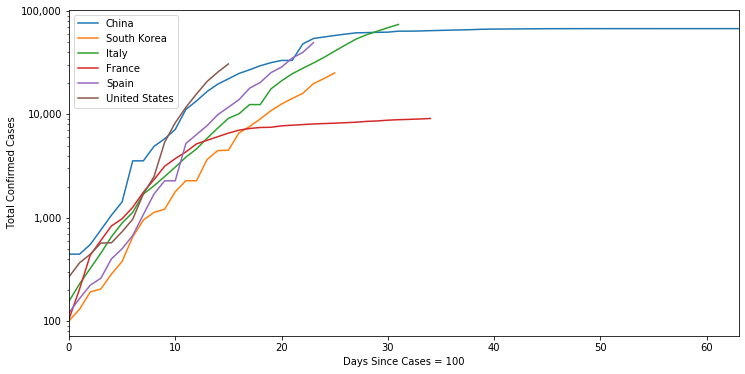

In [26]:
ax = plt.gca()
p=jhu_data_t0[jhu_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', 
                                                                                     y='total', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Days Since Cases = 100')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

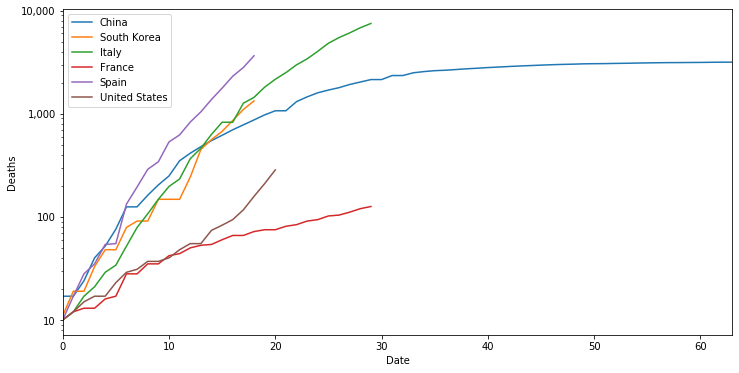

In [43]:
ax = plt.gca()
p=jhu_deaths_data_t0[jhu_deaths_data_t0['location'].isin(country_filter)].groupby('location').plot(x='since_t0', 
                                                                                     y='total', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(country_filter)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [30]:
state_filter = ['Georgia', 'New York', 'California', 'Ohio', 'Washington', 'Louisiana']

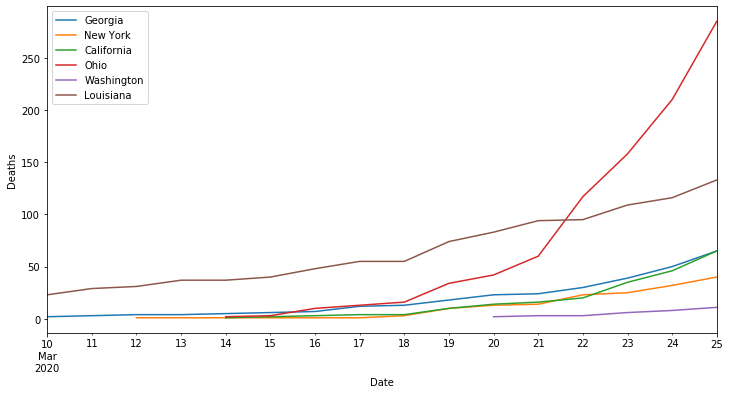

In [42]:
# NOTE: legend does not match lines
ax = plt.gca()
plot_df = jhu_deaths_data_us_reduced[jhu_deaths_data_us_reduced['total']>0]
p=plot_df[plot_df['state'].isin(state_filter)].groupby('state').plot(x='date', y='total', 
                                                                     ax=ax, logy=False)
ax.figure.set_size_inches(12,6)
ax.legend(state_filter)
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'));

jhu_data_us_t0

In [ ]:
ax = plt.gca()
plot_df = jhu_data_us_reduced[jhu_data_us_reduced['total']>0]
p=plot_df[plot_df['state'].isin(state_filter)].groupby('state').plot(x='date', 
                                                                                     y='total', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(state_filter)
ax.set_xlabel('Days Since Cases = 1')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'));

In [214]:
state_abbr = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
state_lookup = state_abbr.set_index('Abbreviation', drop=True).squeeze().to_dict()

In [217]:
covidtracking_reduced['state'] = covidtracking_reduced['state'].map(state_lookup)

In [220]:
covidtracking_reduced = covidtracking_reduced.groupby(['state', 'date']).max()['positive'].reset_index()

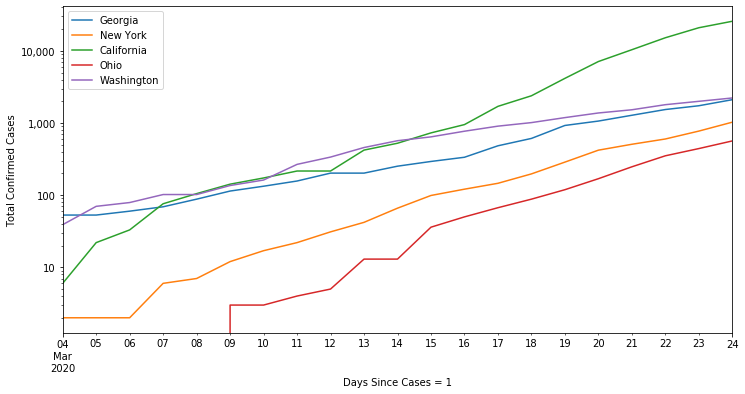

In [224]:
ax = plt.gca()
p=covidtracking_reduced[covidtracking_reduced['state'].isin(state_filter)].groupby('state').plot(x='date', 
                                                                                     y='positive', 
                                                                                     ax=ax, logy=True)
ax.figure.set_size_inches(12,6)
ax.legend(state_filter)
ax.set_xlabel('Days Since Cases = 1')
ax.set_ylabel('Total Confirmed Cases')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

In [97]:
top25_states = covidtracking_reduced.groupby('state').max()['total'].sort_values(ascending=False)[:25].keys()

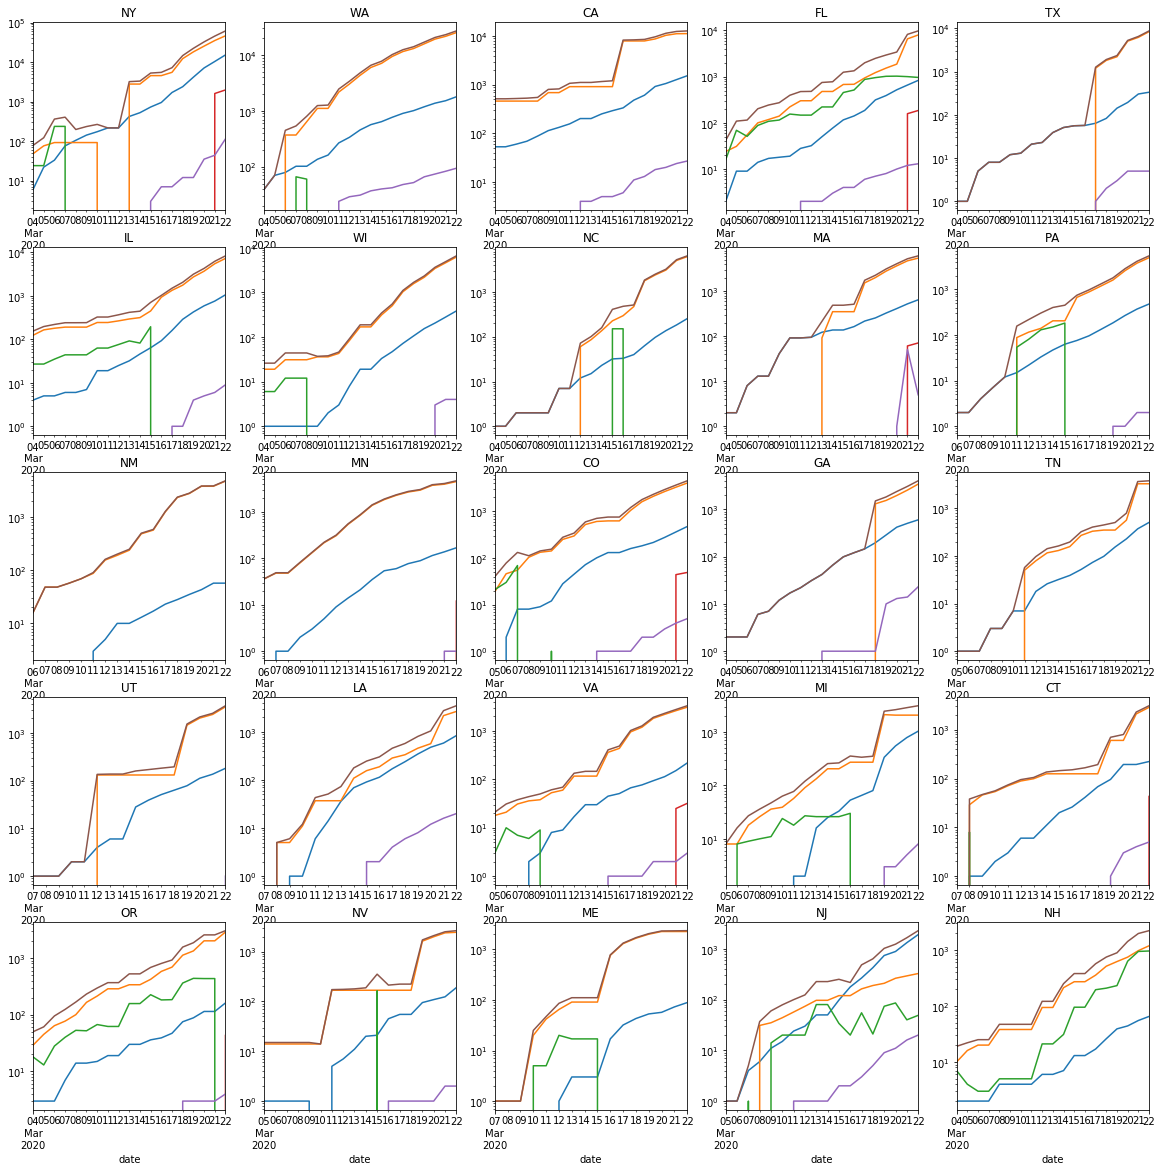

In [99]:
fig = plt.figure(figsize=(20,20))
ax_list = fig.subplots(5, 5).flatten()
for ix, state in enumerate(top25_states):
    if ix > 24:
        continue
    plot_data = covidtracking_reduced.query('state == @state').drop(columns='state').set_index('date')
    plot_data.plot(ax=ax_list[ix],legend=False, title=state, logy=True)